<a href="https://colab.research.google.com/github/PRAGYA-PRANSHU/DDOS_Models/blob/main/hybrid_ml_model_for_network_intrusion_detection(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# import relevant modules
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import imblearn

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
# Settings
import sys
pd.set_option('display.max_columns', None)
np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(precision=3)
sns.set(style="darkgrid")
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# LOAD DATA

In [5]:
train = pd.read_csv("/content/drive/MyDrive/ldap ddos data/DrDoS_LDAP_0.csv")
test = pd.read_csv("/content/drive/MyDrive/ldap ddos data/DrDoS_LDAP_1.csv")

# SCALING NUMERICAL ATTRIBUTES

In [6]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# extract numerical attributes and scale it to have zero mean and unit variance  
cols = train.select_dtypes(include=['float64','int64']).columns
sc_train = scaler.fit_transform(train.select_dtypes(include=['float64','int64']))
sc_test = scaler.fit_transform(test.select_dtypes(include=['float64','int64']))


# turn the result back to a dataframe
sc_traindf = pd.DataFrame(sc_train, columns = cols)
sc_testdf = pd.DataFrame(sc_test, columns = cols)

In [7]:
sc_testdf = pd.DataFrame(sc_testdf)
for col in sc_testdf.columns:
    if 'Total Fwd Packets' in col:
        del sc_testdf[col]


# ENCODING CATEGORICAL ATTRIBUTES

In [8]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

# extract categorical attributes from both training and test sets 
cattrain = train.select_dtypes(include=['object']).copy()
cattest = test.select_dtypes(include=['object']).copy()

# encode the categorical attributes
traincat = cattrain.apply(encoder.fit_transform)
testcat = cattest.apply(encoder.fit_transform)

# separate target column from encoded data 
enctrain = traincat.drop([' Label'], axis=1)
cat_Ytrain = traincat[[' Label']].copy()


In [9]:
train_x = pd.concat([sc_traindf,enctrain],axis=1)
train_y = train[' Label']
train_x.shape

(2000, 79)

In [10]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer.fit(train_x)
train_x = imputer.transform(train_x)

In [11]:
train_x = pd.DataFrame(train_x)

In [12]:
test_df = pd.concat([sc_testdf,testcat],axis=1)
test_df.shape

(15457, 79)

In [13]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer.fit(test_df)
test_df = imputer.transform(test_df)

# FEATURE SELECTION

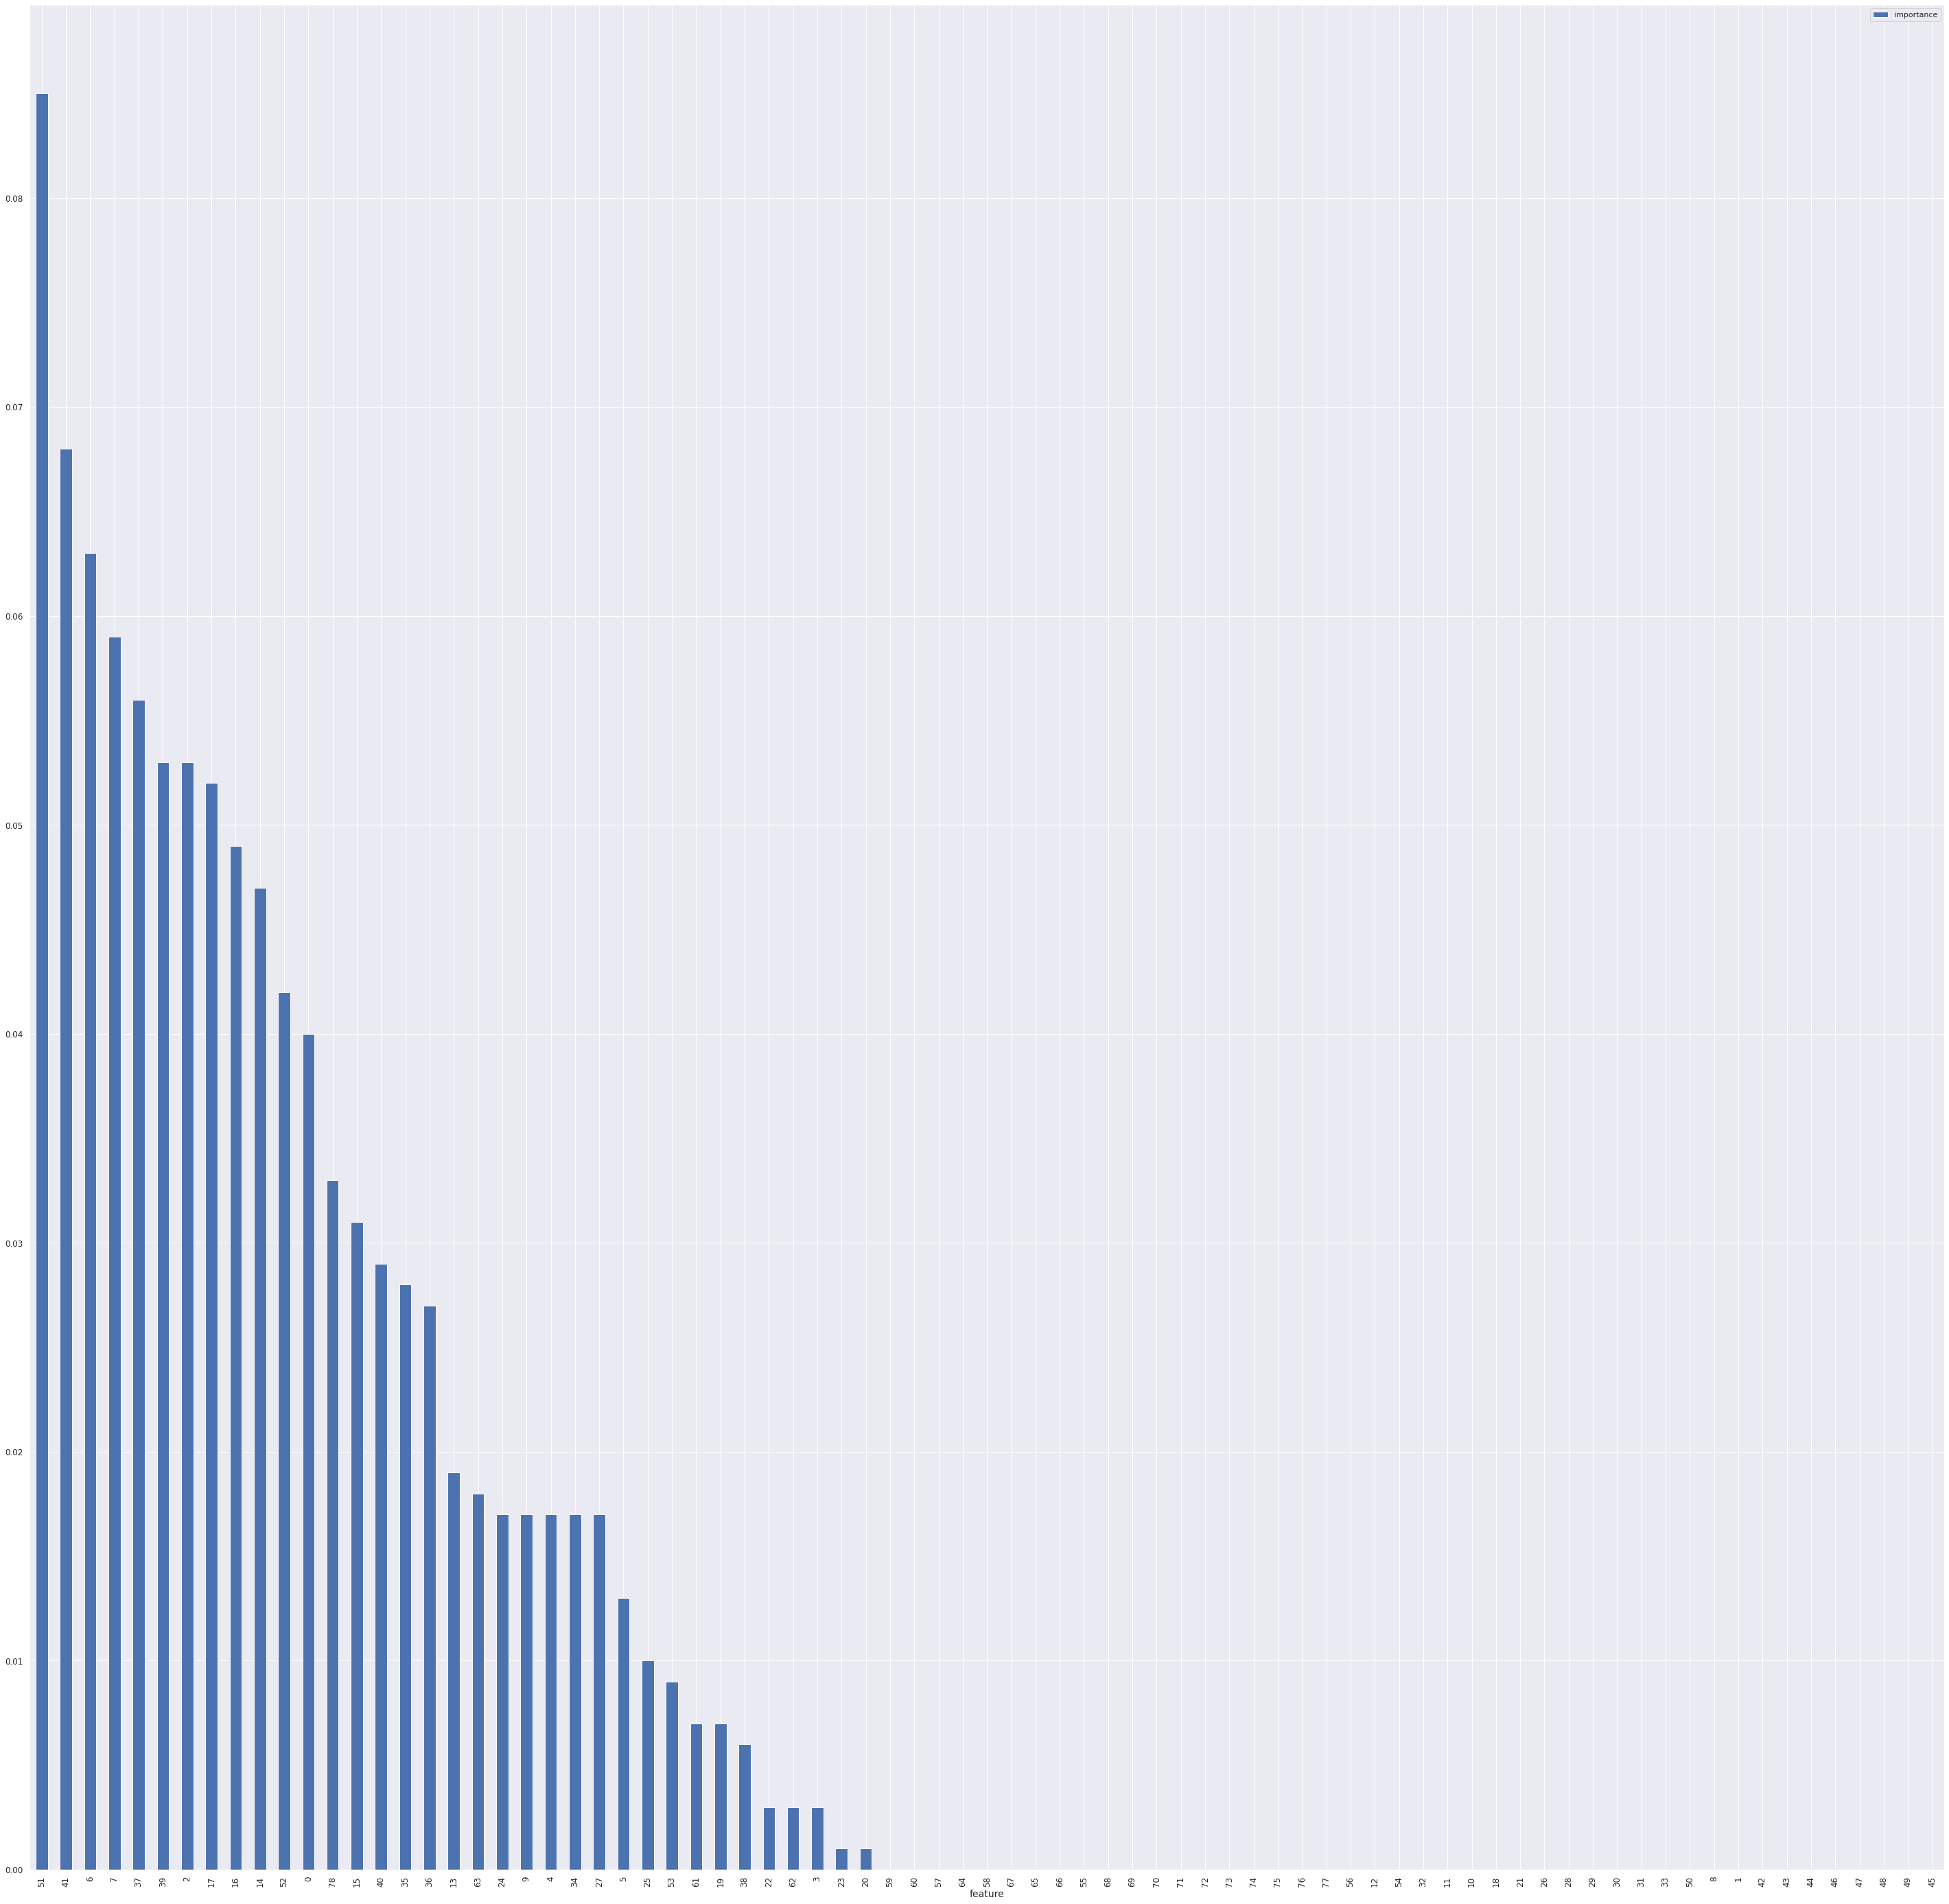

In [14]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier();

# fit random forest classifier on the training set
rfc.fit(train_x, train_y);
# extract important features
score = np.round(rfc.feature_importances_,3)
importances = pd.DataFrame({'feature':train_x.columns,'importance':score})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
# plot importances
plt.rcParams['figure.figsize'] = (50, 50)
importances.plot.bar();

In [15]:
from sklearn.feature_selection import RFE
import itertools
rfc = RandomForestClassifier()

# create the RFE model and select 10 attributes
rfe = RFE(rfc, n_features_to_select=15)
rfe = rfe.fit(train_x, train_y)

# summarize the selection of the attributes
feature_map = [(i, v) for i, v in itertools.zip_longest(rfe.get_support(), train_x.columns)]
selected_features = [v for i, v in feature_map if i==True]

selected_features

[0, 5, 6, 7, 13, 15, 17, 27, 37, 38, 39, 51, 52, 62, 78]

# DATASET PARTITION

In [16]:
from sklearn.model_selection import train_test_split

X_train,X_test,Y_train,Y_test = train_test_split(train_x,train_y,train_size=0.10, stratify=train_y, random_state=2)

# FITTING MODELS

In [17]:
from sklearn.svm import SVC 
from sklearn.naive_bayes import BernoulliNB 
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# Train KNeighborsClassifier Model
KNN_Classifier = KNeighborsClassifier(n_jobs=-1)
KNN_Classifier.fit(X_train, Y_train); 

# Train LogisticRegression Model
LGR_Classifier = LogisticRegression(n_jobs=-1, random_state=42)
LGR_Classifier.fit(X_train, Y_train);

# Train Gaussian Naive Baye Model
BNB_Classifier = BernoulliNB()
BNB_Classifier.fit(X_train, Y_train)
            
# Train Decision Tree Model
DTC_Classifier = tree.DecisionTreeClassifier(criterion='entropy', random_state=0)
DTC_Classifier.fit(X_train, Y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

# EVALUATE MODELS

In [19]:
from sklearn import metrics

models = []
models.append(('Naive Baye Classifier', BNB_Classifier))
models.append(('Decision Tree Classifier', DTC_Classifier))
models.append(('KNeighborsClassifier', KNN_Classifier))
models.append(('LogisticRegression', LGR_Classifier))


for i, v in models:
    scores = cross_val_score(v, X_train, Y_train, cv=5)
    accuracy = metrics.accuracy_score(Y_train, v.predict(X_train))
    confusion_matrix = metrics.confusion_matrix(Y_train, v.predict(X_train))
    classification = metrics.classification_report(Y_train, v.predict(X_train))
    print()
    print('============================== {} Model Evaluation =============================='.format(i))
    print()
    print ("Cross Validation Mean Score:" "\n", scores)
    print()
    print ("Model Accuracy:" "\n", accuracy)
    print()
    print("Confusion matrix:" "\n", confusion_matrix)
    print()
    print("Classification report:" "\n", classification) 
    print()


============================== Naive Baye Classifier Model Evaluation ==============================

Cross Validation Mean Score:
 [0.975 1.    1.    1.    1.   ]

Model Accuracy:
 0.995

Confusion matrix:
 [[100   0]
 [  1  99]]

Classification report:
               precision    recall  f1-score   support

      BENIGN       0.99      1.00      1.00       100
  DrDoS_LDAP       1.00      0.99      0.99       100

    accuracy                           0.99       200
   macro avg       1.00      0.99      0.99       200
weighted avg       1.00      0.99      0.99       200



============================== Decision Tree Classifier Model Evaluation ==============================

Cross Validation Mean Score:
 [0.975 1.    1.    1.    1.   ]

Model Accuracy:
 1.0

Confusion matrix:
 [[100   0]
 [  0 100]]

Classification report:
               precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00       100
  DrDoS_LDAP       1.00      1.00      1.00     

# VALIDATING MODELS

In [20]:
for i, v in models:
    accuracy = metrics.accuracy_score(Y_test, v.predict(X_test))
    confusion_matrix = metrics.confusion_matrix(Y_test, v.predict(X_test))
    classification = metrics.classification_report(Y_test, v.predict(X_test))
    print()
    print('============================== {} Model Test Results =============================='.format(i))
    print()
    print ("Model Accuracy:" "\n", accuracy)
    print()
    print("Confusion matrix:" "\n", confusion_matrix)
    print()
    print("Classification report:" "\n", classification) 
    print()        



============================== Naive Baye Classifier Model Test Results ==============================

Model Accuracy:
 1.0

Confusion matrix:
 [[900   0]
 [  0 900]]

Classification report:
               precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00       900
  DrDoS_LDAP       1.00      1.00      1.00       900

    accuracy                           1.00      1800
   macro avg       1.00      1.00      1.00      1800
weighted avg       1.00      1.00      1.00      1800



============================== Decision Tree Classifier Model Test Results ==============================

Model Accuracy:
 0.9844444444444445

Confusion matrix:
 [[872  28]
 [  0 900]]

Classification report:
               precision    recall  f1-score   support

      BENIGN       1.00      0.97      0.98       900
  DrDoS_LDAP       0.97      1.00      0.98       900

    accuracy                           0.98      1800
   macro avg       0.98      0.98      0.98     

In [21]:
# PREDICTING FOR TEST DATA using KNN
pred_knn = KNN_Classifier.predict(test_df)
pred_NB = BNB_Classifier.predict(test_df)
pred_log = LGR_Classifier.predict(test_df)
pred_dt = DTC_Classifier.predict(test_df)

# Extracting TP FP TN FN

In [22]:
def perf_measure(y_actual, y_pred):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_pred)): 
        if y_actual.iat[i]==y_pred[i]=='BENIGN':
           TP += 1
        if y_pred[i]=='DrDoS_NetBIOS' and y_actual.iat[i]!=y_pred[i]:
           FP += 1
        if y_actual.iat[i]==y_pred[i]=='DrDoS_NetBIOS':
           TN += 1
        if y_pred[i]=='BENIGN' and y_actual.iat[i]!=y_pred[i]:
           FN += 1
        
    return (TP, FP, TN, FN)


for i, v in models:
    print("For model:", i)
    TP, FP, TN, FN = perf_measure(Y_test, v.predict(X_test))
    print ("TP:", TP, "\tFP:", FP, "\t\tTN:", TN, "\tFN:", FN)
    
    # Testing for first row
    #print ("Expected: ", Y_test.iloc[0], "Predicted: ", v.predict(X_test).reshape(1, -1)[0][0] )
    print()
    

For model: Naive Baye Classifier
TP: 900 	FP: 0 		TN: 0 	FN: 0

For model: Decision Tree Classifier
TP: 872 	FP: 0 		TN: 0 	FN: 0

For model: KNeighborsClassifier
TP: 895 	FP: 0 		TN: 0 	FN: 0

For model: LogisticRegression
TP: 893 	FP: 0 		TN: 0 	FN: 0



In [23]:
# Testing for second row
for i, v in models:
    print("For model: ", i)
    print ("Expected: ", Y_test.iloc[2], "\tPredicted: ", v.predict(X_test).reshape(1, -1)[0][2] )
    print()

For model:  Naive Baye Classifier
Expected:  BENIGN 	Predicted:  BENIGN

For model:  Decision Tree Classifier
Expected:  BENIGN 	Predicted:  BENIGN

For model:  KNeighborsClassifier
Expected:  BENIGN 	Predicted:  BENIGN

For model:  LogisticRegression
Expected:  BENIGN 	Predicted:  BENIGN



In [24]:
type(Y_test)

pandas.core.series.Series

# Functions to extract locations of FP, FN as a pandas series

In [25]:
def find_FP(y_actual, y_pred):
    FP = []

    for i in range(len(y_pred)): 
        if y_pred[i]=='DrDoS_NetBIOS' and y_actual.iat[i]!=y_pred[i]:
           FP.append(i)   
    return (pd.Series(FP))
    
def find_FN(y_actual, y_pred):
    FN = []

    for i in range(len(y_pred)): 
        if y_pred[i]=='BENIGN' and y_actual.iat[i]!=y_pred[i]:
           FN.append(i)
    return (pd.Series(FN))


# Combining Naive Bayes and Decision Tree

## Getting FP and FN row location from NB output as pd.Series

In [26]:
FP_NB= find_FP(Y_test, models[0][1].predict(X_test))
print("Size of number of FP:", FP_NB.size) 
FN_NB= find_FN(Y_test, models[0][1].predict(X_test))
print("Size of number of FN:", FN_NB.size) 

# Testing 
FP_NB.head(4)

Size of number of FP: 0
Size of number of FN: 0


Series([], dtype: float64)

## Getting FP FN row entry from X_test and Y_test as pd.DataFrame and pd.Series respectively

In [27]:
X_test_subset=[]
Y_test_subset=[]
for i in FP_NB:
    X_test_subset.append(X_test.iloc[i])
    Y_test_subset.append(Y_test.iat[i])
for i in FN_NB:
    X_test_subset.append(X_test.iloc[i])
    Y_test_subset.append(Y_test.iat[i])
    
X_test_sub=pd.DataFrame(X_test_subset)
Y_test_sub=pd.Series(Y_test_subset)
print("Size of X_test_sub:", X_test_sub.shape[0]) 
print("Size of Y_test_sub:", Y_test_sub.size) 

# To check for each false positive
#for i in FP_NB:
#    print ("Expected: ", Y_test.iloc[i], "Predicted: ", models[1][1].predict(X_test).reshape(1, -1)[0][i] )

Size of X_test_sub: 0
Size of Y_test_sub: 0


In [28]:
print(type(X_test)) 
X_test.head(4)

<class 'pandas.core.frame.DataFrame'>


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78
457,-0.294325,-0.330286,-0.019260,1.354157,-0.163213,2.625079,0.865855,1.568652,3.411627,-0.126405,-0.351537,-0.004190,0.131692,-0.954325,-0.953726,-0.122168,-0.150181,-0.210671,-0.083956,-0.320042,-0.165578,-0.214059,-0.268482,-0.083942,-0.273828,-0.218524,-0.193320,-0.211860,-0.202885,-0.373632,0.0,0.0,0.0,0.271710,-0.062078,-0.954179,6.231168,-1.017756,1.585400,-0.068906,2.688686,3.236305,0.0,0.0,-0.373632,0.0,-0.569652,2.312835,0.0,0.0,3.891484,-0.330907,1.568652,-0.004190,0.271710,0.0,0.0,0.0,0.0,0.0,0.0,-0.330286,1.354157,-0.019260,-0.163213,1.848615,-0.037643,-0.204469,0.272238,-0.059265,0.0,-0.059265,-0.059265,-0.059265,0.0,-0.059265,-0.059265,0.0,-1.006018
150,0.007958,1.162800,1.089633,0.035793,0.364133,-0.705872,-1.032072,-1.023071,0.374364,2.145606,-0.351537,0.836697,1.397018,-0.954668,-0.954113,-0.112917,-0.118829,-0.169283,-0.083956,-0.047881,-0.128203,-0.129041,-0.159329,-0.083953,0.111241,-0.038341,-0.059200,-0.083182,-0.039334,-0.373632,0.0,0.0,0.0,0.271711,0.981207,-0.954247,2.282551,-1.017756,1.603831,-0.931051,1.127535,0.548696,0.0,0.0,-0.373632,0.0,1.755458,-0.432370,0.0,0.0,1.666507,-0.971074,-1.023071,0.836697,0.271711,0.0,0.0,0.0,0.0,0.0,0.0,1.162800,0.035793,1.089633,0.364133,0.656884,-0.111355,1.643421,0.272238,-0.059265,0.0,-0.059265,-0.059265,-0.059265,0.0,-0.059265,-0.059265,0.0,-1.006018
570,0.179816,0.062631,-0.019260,-0.667055,-0.129989,-0.821868,-1.032072,-1.032868,0.496044,0.124061,-0.351537,0.323936,0.540585,-0.954736,-0.954474,-0.014549,0.192078,0.169385,-0.083951,0.192968,0.046274,0.306747,0.277729,-0.083953,-0.126388,0.116664,-0.021910,-0.094037,-0.039334,-0.373632,0.0,0.0,0.0,0.271710,-0.000101,-0.954407,-0.209100,-1.017756,-0.732618,-1.079959,0.344140,-0.165607,0.0,0.0,-0.373632,0.0,1.755458,-0.432370,0.0,0.0,-0.558469,-1.061503,-1.032868,0.323936,0.271710,0.0,0.0,0.0,0.0,0.0,0.0,0.062631,-0.667055,-0.019260,-0.129989,0.656884,-0.113282,-0.204469,0.272238,-0.059265,0.0,-0.059265,-0.059265,-0.059265,0.0,-0.059265,-0.059265,0.0,-1.006018
276,0.409771,0.534132,0.389280,0.897348,0.305650,0.925235,-1.032072,-0.713304,2.326872,2.618395,-0.351537,1.843183,2.534143,-0.954707,-0.954445,-0.047711,0.099900,0.160829,-0.083951,0.424860,0.000027,0.168119,0.266074,-0.083953,0.166228,0.196700,0.062434,-0.031703,-0.039334,-0.373632,0.0,0.0,0.0,0.271710,0.320116,-0.954396,0.022671,-1.017756,2.150267,-0.593911,2.240225,2.291911,0.0,0.0,-0.373632,0.0,1.755458,-0.432370,0.0,0.0,-0.558469,-0.741661,-0.713304,1.843183,0.271710,0.0,0.0,0.0,0.0,0.0,0.0,0.534132,0.897348,0.389280,0.305650,0.656884,7.917432,0.534687,0.272238,-0.059265,0.0,-0.059265,-0.059265,-0.059265,0.0,-0.059265,-0.059265,0.0,-1.006018


In [29]:
print(type(X_test_sub))
X_test_sub.head(4)


<class 'pandas.core.frame.DataFrame'>


""


In [30]:
print(type(Y_test)) 
Y_test.head(4)

<class 'pandas.core.series.Series'>


457    BENIGN
150    BENIGN
570    BENIGN
276    BENIGN
Name:  Label, dtype: object

In [31]:
print(type(Y_test_sub))
Y_test_sub.head(4)

<class 'pandas.core.series.Series'>


Series([], dtype: float64)

# Validating the combined model

## Validating results for the FP FN subset in the combined model

In [33]:
accuracy = metrics.accuracy_score(Y_test_sub, models[1][1].predict(X_test_sub))
confusion_matrix = metrics.confusion_matrix(Y_test_sub, models[1][1].predict(X_test_sub))
classification = metrics.classification_report(Y_test_sub, models[1][1].predict(X_test_sub))
print()
print('============================== {} Model Test Results =============================='.format("NB -> DT"))
print()
print ("Model Accuracy:" "\n", accuracy)
print()
print("Confusion matrix:" "\n", confusion_matrix)
print()
print("Classification report:" "\n", classification) 
print() 

ValueError: ignored

## Validating hybrid model, NB + DT

In [35]:
print("For Naive Bayes:")
TP_old, FP_old, TN_old, FN_old = perf_measure(Y_test, BNB_Classifier.predict(X_test))
print ("TP:", TP_old, "\tFP:", FP_old, "\t\tTN:", TN_old, "\tFN:", FN_old)

print()
print("For Naive Bayes -> Decision Tress:")
TP_new, FP_new, TN_new, FN_new = perf_measure(Y_test_sub, DTC_Classifier.predict(X_test_sub))
print ("TP:", TP_new, "\tFP:", FP_new, "\t\tTN:", TN_new, "\tFN:", FN_new)

print()
print("For Naive Bayes + Decision Tress:")
tp = TP_old +TP_new
fp = FP_new
tn = TN_old +TN_new
fn = FN_new
print ("TP:", tp, "\tFP:", fp, "\t\tTN:", tn, "\tFN:", fn)

For Naive Bayes:
TP: 900 	FP: 0 		TN: 0 	FN: 0

For Naive Bayes -> Decision Tress:


ValueError: ignored

## 1. Accuracy (all correct / all) = TP + TN / TP + TN + FP + FN
## 2. Misclassification (all incorrect / all) = FP + FN / TP + TN + FP + FN
## 3. Precision (true positives / predicted positives) = TP / TP + FP
## 4. Sensitivity aka Recall (true positives / all actual positives) = TP / TP + FN
## 5. Specificity (true negatives / all actual negatives) =TN / TN + FP

In [34]:
acc_old= (TP_old + TN_old) / (TP_old + FP_old + TN_old + FN_old)
mis_old= (FP_old + FN_old) / (TP_old + FP_old + TN_old + FN_old)
prec_old= TP_old / (TP_old + FP_old)
sen_old= TP_old / (TP_old + FN_old)
spec_old= TN_old / (TN_old + FP_old)

acc= (tp + tn) / (tp + fp + tn + fn)
mis= (fp + fn) / (tp + fp + tn + fn)
prec= tp / (tp + fp)
sen= tp / (tp + fn)
spec= tn / (tn + fp)

print ("Accuracy")
print ("Old: ", acc_old, "\tNew: ", acc)
print ("\nMisclassification")
print ("Old: ", mis_old, "\tNew: ", mis)
print ("\nPrecision")
print ("Old: ", prec_old, "\tNew: ", prec)
print ("\nSensitivity")
print ("Old: ", sen_old, "\tNew: ", sen)
print ("\nSpecificity")
print ("Old: ", spec_old, "\tNew: ", spec)

NameError: ignored

# Plotting Results

In [ ]:
# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))
 
# set height of bar
NB = [TP_old, FP_old, TN_old, FN_old]
NBandDT = [tp, fp, tn, fn]
 
# Set position of bar on X axis
br1 = np.arange(len(NB))
br2 = [x + barWidth for x in br1]
 
# Make the plot
plt.bar(br1, NB, color ='b', width = barWidth, edgecolor ='grey', label ='Naive Bayes')
plt.bar(br2, NBandDT, color ='g', width = barWidth, edgecolor ='grey', label ='Naive Bayes and Decision Tree')
 
# Adding Xticks
plt.xlabel('Confusion Matrix Element', fontweight ='bold', fontsize = 15)
plt.ylabel('Value', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(NB))], ['TP', 'FP', 'TN', 'FN'])
 
plt.legend()
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))
 
# set height of bar
Old = [acc_old, mis_old, prec_old, sen_old, spec_old]
New = [acc, mis, prec, sen, spec]
 
# Set position of bar on X axis
br1 = np.arange(len(Old))
br2 = [x + barWidth for x in br1]
 
# Make the plot
plt.bar(br1, Old, color ='b', width = barWidth, edgecolor ='grey', label ='Old')
plt.bar(br2, New, color ='g', width = barWidth, edgecolor ='grey', label ='New')


# Adding Xticks
plt.xlabel('Performance Metrics', fontweight ='bold', fontsize = 15)
plt.ylabel('Value', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(NB))], ['Accuracy', 'Misclassification', 'Precision', 'Sensitivity', 'Specificity'])
 
plt.legend()
plt.title("Comparison of performance metrics")
plt.show()

In [ ]:
accPercent= ((acc- acc_old)/acc_old) *100
misPercent= ((mis_old- mis)/mis_old) *100
precPercent= ((prec- prec_old)/prec_old) *100
senPercent= ((sen- sen_old)/sen_old) *100
specPercent= ((spec- spec_old)/spec_old) *100

print ("Accuracy increase percentage: " ,accPercent, "%")
print ("Missclasification decrease percentage: " ,misPercent, "%")
print ("Precison increase percentage: ", precPercent, "%")
print ("Sensitivity increase percentage: ", senPercent, "%")
print ("Specificity increase percentage: ", specPercent, "%")